# IMPORT DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
import time
import shutil
import pathlib
import itertools
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.metrics import Precision, Recall, AUC
from google.colab import runtime
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve
import keras_hub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA

In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [4]:
TfDatasetsPath = '/content/drive/MyDrive/CSEN-240-Project/TfDatasets'
# TfDatasetsPath = 'TfDatasets'

In [5]:
trainDataset = tf.data.Dataset.load(TfDatasetsPath + "/trainDataset")
validDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

In [6]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_flip_up_down(image)
    image - tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [7]:
augmentedDataset = trainDataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
trainDataset = trainDataset.concatenate(augmentedDataset)

In [8]:
len(trainDataset), len(validDataset), len(testDataset)

(6048, 378, 378)

In [9]:
trainDataset = trainDataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validDataset = validDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
trainDataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [11]:
metrics = [Precision(), Recall(), AUC(), 'accuracy']

# VGG16 Model

In [12]:
def createModel(input_shape, num_classes=3, learning_rate=1e-4):
    inputs = tf.keras.layers.Input(shape=input_shape)
    base_model = tf.keras.applications.VGG16(weights="imagenet", input_tensor=inputs, include_top=False)
    base_model.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
    return model

# TRAINING

In [13]:
input_shape = (224, 224, 3)
model = createModel(input_shape, num_classes=3, learning_rate=1e-4)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 15,112,515 (57.65 MB)

 Trainable params: 396,291 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True)

In [16]:
# Defining The ReduceLRonPlateau Callback
reduceLRCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.8, # How much to improve the learning rate -> LR = LR*factor
    patience=3,
    verbose=1,
    mode='max',
    min_delta=0.0001, # Change in metric below this delta is considered as no change
    cooldown=0, # Number of epochs to wait before resuming normal operation after lr has been improved
    min_lr=0 # Learning Rate won't go below this
)

In [17]:
history = model.fit(trainDataset,
                        validation_data=validDataset,
                        epochs=250,
                        callbacks=[early_stopping, reduceLRCallback],
                        verbose=1)

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 63s 190ms/step - accuracy: 0.5173 - auc: 0.7046 - loss: 1.1796 - precision: 0.5310 - recall: 0.4677 - val_accuracy: 0.4233 - val_auc: 0.6550 - val_loss: 1.0126 - val_precision: 0.6075 - val_recall: 0.1720 - learning_rate: 1.0000e-04
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.6063 - auc: 0.7917 - loss: 0.9539 - precision: 0.6254 - recall: 0.5646 - val_accuracy: 0.5926 - val_auc: 0.8032 - val_loss: 0.8249 - val_precision: 0.7124 - val_recall: 0.4259 - learning_rate: 1.0000e-04
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.6385 - auc: 0.8186 - loss: 0.8731 - precision: 0.6632 - recall: 0.6062 - val_accuracy: 0.6534 - val_auc: 0.8334 - val_loss: 0.7684 - val_precision: 0.6867 - val_recall: 0.6032 - learning_rate: 1.0000e-04
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.6530 - auc: 0.8337 - loss: 0.8179 - precision: 0.6697 - recall: 0.6128 - val_accuracy: 0.6323 - val_auc: 0.8322

# FINE-TUNING

In [18]:
for layer in model.layers[1:-8]:
    layer.trainable = True

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss="categorical_crossentropy", metrics=metrics)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 15,112,515 (57.65 MB)

 Trainable params: 15,110,979 (57.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [21]:
history = model.fit( trainDataset,
                         validation_data=validDataset,
                         epochs=250,
                         callbacks=[early_stopping, reduceLRCallback],
                         verbose=1)

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 89s 269ms/step - accuracy: 0.5856 - auc: 0.8017 - loss: 1.0240 - precision: 0.6320 - recall: 0.5815 - val_accuracy: 0.4762 - val_auc: 0.6264 - val_loss: 3.0751 - val_precision: 0.4762 - val_recall: 0.4762 - learning_rate: 5.0000e-05
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 49s 255ms/step - accuracy: 0.6361 - auc: 0.8163 - loss: 0.8807 - precision: 0.6589 - recall: 0.5928 - val_accuracy: 0.4868 - val_auc: 0.6430 - val_loss: 2.0261 - val_precision: 0.4906 - val_recall: 0.4841 - learning_rate: 5.0000e-05
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 49s 255ms/step - accuracy: 0.6597 - auc: 0.8359 - loss: 0.8195 - precision: 0.6887 - recall: 0.6109 - val_accuracy: 0.4153 - val_auc: 0.6645 - val_loss: 2.3984 - val_precision: 0.4071 - val_recall: 0.3942 - learning_rate: 5.0000e-05
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 49s 255ms/step - accuracy: 0.6766 - auc: 0.8480 - loss: 0.7831 - precision: 0.7037 - recall: 0.6308 - val_accuracy: 0.5688 - val_auc: 0.7

# PLOTS

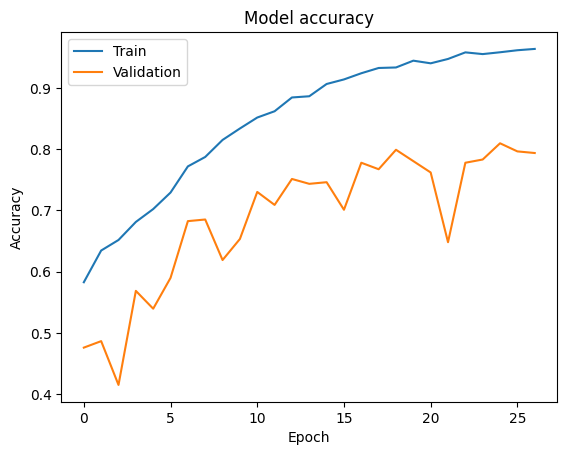

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

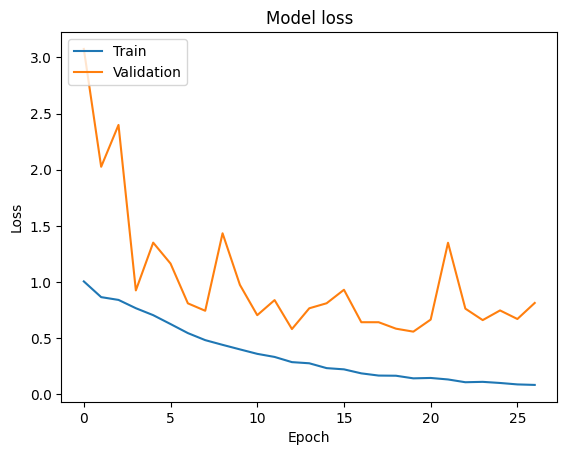

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# PR Curve

In [24]:
valid_labels = []
for xBatch, yBatch in validDataset:
    valid_labels.extend(np.argmax(yBatch, axis=1))
predictions = model.predict(validDataset)
predicted_classes = np.argmax(predictions, axis=1)
yTrue = np.eye(3)[valid_labels]
yPred = predictions
thresholds = {}

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


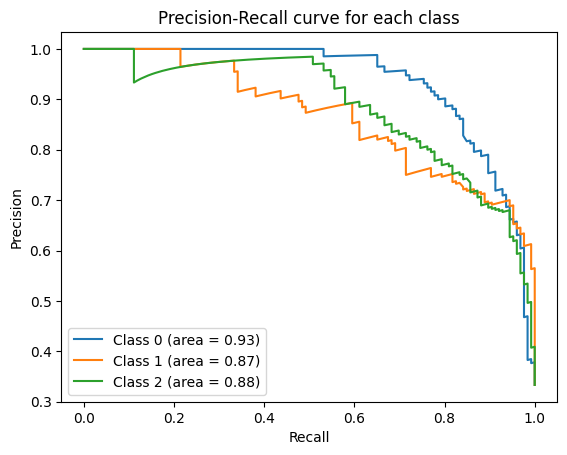

In [25]:
for class_idx in range(3):
    precision, recall, thresholds_pr = precision_recall_curve(yTrue[:, class_idx], yPred[:, class_idx])

    f1_scores = 2 * (precision * recall) / (precision + recall)

    optimal_threshold_pr = thresholds_pr[np.argmax(f1_scores)]
    thresholds[class_idx] = optimal_threshold_pr

    plt.plot(recall, precision, label=f'Class {class_idx} (area = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="best")
plt.show()

In [26]:
print("Optimal thresholds for each class (based on maximum F1 score):")
for class_idx, threshold in thresholds.items():
    print(f"Class {class_idx}: {threshold}")

Optimal thresholds for each class (based on maximum F1 score):
Class 0: 0.5739341974258423
Class 1: 0.1319325715303421
Class 2: 0.266340047121048


# TESTING

In [27]:
def customPredict(yPred, thresholds):
    predictions = np.zeros_like(yPred)
    for i in thresholds.keys():
        threshold = thresholds[i]
        predictions[:, i] = (yPred[:, i] >= threshold).astype(int)
    predictions = np.argmax(predictions * yPred, axis=1)
    return predictions

In [28]:
test_labels = []
for xBatch, yBatch in testDataset:
    test_labels.extend(np.argmax(yBatch, axis=1))
predictions = customPredict(model.predict(testDataset), thresholds)
# predictions = np.argmax(model.predict(testDataset), axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [29]:
report = classification_report(test_labels, predictions, target_names=categories)
print(report)

              precision    recall  f1-score   support

      Normal       0.89      0.86      0.87       126
  Osteopenia       0.83      0.87      0.85       126
Osteoporosis       0.87      0.87      0.87       126

    accuracy                           0.87       378
   macro avg       0.87      0.87      0.87       378
weighted avg       0.87      0.87      0.87       378



Text(95.72222222222221, 0.5, 'True Label')

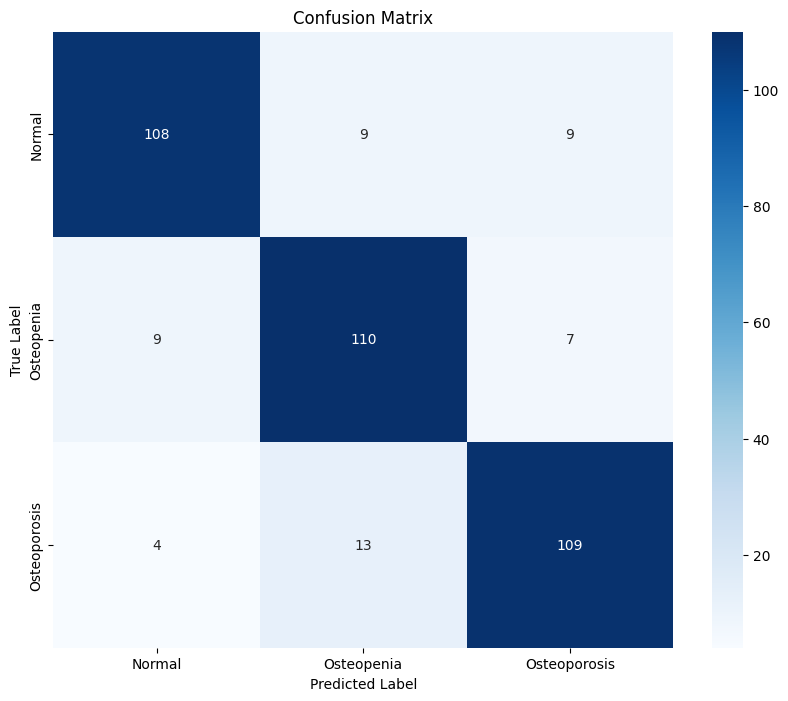

In [30]:
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [31]:
runtime.unassign()